# Experiment on AAI Model Architectures
- Created: 10 Mar 2020
- Data: param_draft2 20k
- Model 4 5

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from os.path import join
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import callbacks
from time import time
from datetime import datetime
import shutil 
import argparse
from functools import partial
import pickle
from IPython.display import Audio

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Reshape, GRU, InputLayer, AlphaDropout, Activation, BatchNormalization, Dropout, Flatten, Dense, Bidirectional, LSTM, Conv1D, SpatialDropout1D, Concatenate, Multiply, Add

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder

In [2]:
np_load_old = partial(np.load)
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

In [3]:
tf.random.set_seed(42)

## Metric Function

In [4]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

def R2(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred), axis = 0) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true, axis = 0)), axis = 0) 
    return K.mean(1 - (SS_res/SS_tot), axis=0)

## Utility Functions

In [5]:
#Function for preprocessing data
def delete_params(params):
    '''
    This function remove JX, WC, TRX, TRY, and MS1,2,3 paramter
    '''
    DEL_PARAMS_LIST = [2,8,15,16,21,22,23]
    return np.delete(params,DEL_PARAMS_LIST , axis=1)

In [6]:
def compute_rmse(actual,pred, axis=1):
    # Compute RMSE by row (axis=1) result in rmse of each data
    # Compute RMSE by column (axis=0) result in rmse of each label
    return np.sqrt((np.square(actual - pred)).mean(axis=axis))

In [7]:
def evaluate_model(y_pred, label):
    y_pred = enc.inverse_transform(y_pred)
    label = enc.inverse_transform(label)
#     print('Confusion Matrix')
#     print(confusion_matrix(label, y_pred))
    print('Classification Report')
    print(classification_report(label, y_pred))

In [8]:
def compute_se(actual,pred):
    return np.sqrt((np.square(actual - pred)))

## Load Data 

In [9]:
def prep_data():

    # load data from preprocess pipeline
    dataset = np.load(join('../../data/d_dataset_p2/prep_data_13','training_subsets.npz'))
    X_train =dataset['X_train']
    y_train= dataset['y_train']
    z_train= dataset['z_train']
    X_val = dataset['X_val']
    y_val = dataset['y_val']
    z_val = dataset['z_val']
    X_test = dataset['X_test']
    y_test = dataset['y_test']
    z_test = dataset['z_test']
    a_test = dataset['audio_test']
    a_val = dataset['audio_val']
    
    y_train = delete_params(y_train)
    y_val = delete_params(y_val)
    y_test = delete_params(y_test)

    print('Train features and labels %s %s'%(str(X_train.shape),str(y_train.shape)))
    print('Validating features and labels %s %s'%(str(X_val.shape),str(y_val.shape)))
    print('Test features and labels %s %s'%(str(X_test.shape),str(y_test.shape)))

    return X_train, X_val, X_test, y_train, y_val, y_test, z_train, z_val, z_test, a_test, a_val

In [10]:
X_train, X_val, X_test, y_train, y_val, y_test, z_train, z_val, z_test, a_test, a_val = prep_data()

Train features and labels (76260, 24, 39) (76260, 17)
Validating features and labels (9340, 24, 39) (9340, 17)
Test features and labels (9338, 24, 39) (9338, 17)


In [11]:
print(set(z_test))

{'e', 'u', 'i', 'O', 'E:', 'E', '9', 'A', 'a', '2', 'y', 'o', 'U', '@'}


In [12]:
print('Train features and labels {} {} {}'.format(str(X_train.shape),str(y_train.shape),str(z_train.shape)))
print('Validating features and labels {} {} {}'.format(str(X_val.shape),str(y_val.shape),str(z_val.shape)))
print('Test features and labels {} {} {}'.format(str(X_test.shape),str(y_test.shape),str(z_test.shape)))

Train features and labels (76260, 24, 39) (76260, 17) (76260,)
Validating features and labels (9340, 24, 39) (9340, 17) (9340,)
Test features and labels (9338, 24, 39) (9338, 17) (9338,)


### One-hot label 

In [13]:
z_train_oe=z_train.reshape(-1,1)
z_val_oe=z_val.reshape(-1,1)
z_test_oe=z_test.reshape(-1,1)

enc = OneHotEncoder(handle_unknown = 'ignore')
enc.fit(z_train_oe)

z_train_oe = enc.transform(z_train_oe).toarray()
z_test_oe = enc.transform(z_test_oe).toarray()
z_val_oe = enc.transform(z_val_oe).toarray()

## 1.) Train Baseline Model
- Model without embedding feature

### Defined Model without Embedded Feature

In [14]:
N_OUTPUTS = 17

pLSTM = partial(LSTM, kernel_initializer='he_uniform', return_sequences=True)
pConv1D = partial(Conv1D, padding = 'same', activation = 'linear', kernel_initializer = 'he_uniform')

def init_senet(feature_layer=1, cnn_unit=64, first_kernel=11, res_unit=128, res_kernel=7,
    bilstm = 1, bilstm_unit=256, 
    dropout_rate=0.3,
    reduction_ratio = 2,
    activation_fn='relu'):


    def cnn_block(input_x, cnn_unit, kernel_size):
        x = pConv1D(cnn_unit, kernel_size=kernel_size)(input_x)
        x = BatchNormalization()(x)
        x = Activation(activation_fn)(x)
        return x

    def se_block(input_x):
        x = layers.GlobalAveragePooling1D()(input_x)
        channel_shape = getattr(x, '_shape_val')[-1]
        x = Reshape((1, channel_shape))(x)
        x = Dense(channel_shape // reduction_ratio, activation=activation_fn, kernel_initializer='he_uniform')(x)
        x = Dense(channel_shape, activation='tanh', kernel_initializer='he_uniform')(x)
        return x

    def residual_block(input_x):
        x = cnn_block(input_x, res_unit,kernel_size=res_kernel)
        x = pConv1D(res_unit, kernel_size=3)(x)
        x = BatchNormalization()(x)
        return x

    def se_res_block(input_x):
        res_x = residual_block(input_x)
        se_x = se_block(res_x)
        x = layers.Multiply()([res_x, se_x])
        x = Activation(activation_fn)(x)
        # input_x = cnn_block(input_x, cnn_unit=cnn_unit, kernel_size=1)
        outputs = layers.Add()([x, input_x])
        return outputs

    def senet_nn(input_shape_1,input_shape_2):

        input_x = keras.Input(shape=(input_shape_1,input_shape_2))
        x = cnn_block(input_x, 128, first_kernel)
        for i in range(feature_layer):
            x = se_res_block(x)
        x = SpatialDropout1D(rate=dropout_rate)(x)
        for i in range(feature_layer):
            x = se_res_block(x)
            x = SpatialDropout1D(rate=dropout_rate)(x)
        x = cnn_block(x, cnn_unit=cnn_unit, kernel_size=1)
        x = SpatialDropout1D(rate=dropout_rate)(x)
        for i in range(bilstm-1):
            x = Bidirectional(pLSTM(bilstm_unit))(x)
            x = SpatialDropout1D(rate=dropout_rate)(x)
        x = Bidirectional(pLSTM(bilstm_unit, return_sequences=False))(x)
        x = Dropout(rate=dropout_rate)(x)
        outputs = Dense(N_OUTPUTS, activation='linear', kernel_initializer='he_uniform')(x)
        model = keras.Model(inputs=input_x, outputs=outputs)
        return model

    return senet_nn

In [15]:
model = init_senet()(24, 39)

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 24, 39)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 24, 128)      55040       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 24, 128)      512         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 24, 128)      0           batch_normalization[0][0]        
______________________________________________________________________________________________

### Compile Model 

In [17]:
model.compile(optimizer='adam',loss='mse',metrics=[rmse, R2])

### Train Model 

In [18]:
PATIENCE = 10
BATCH_SIZE = 128
EPOCHS = 50

early = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=PATIENCE, verbose=1, mode='min', baseline=None, restore_best_weights=False)
callback_list = [early]

In [19]:
history = model.fit(X_train,y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val,y_val),
    callbacks=callback_list)

Train on 76260 samples, validate on 9340 samples
Epoch 1/50
76260/76260 [==============================] - 29s 378us/sample - loss: 0.1043 - rmse: 0.2991 - R2: 0.5770 - val_loss: 0.0428 - val_rmse: 0.1895 - val_R2: 0.8285
Epoch 2/50
76260/76260 [==============================] - 16s 214us/sample - loss: 0.0590 - rmse: 0.2234 - R2: 0.7614 - val_loss: 0.0348 - val_rmse: 0.1711 - val_R2: 0.8595
Epoch 3/50
76260/76260 [==============================] - 16s 215us/sample - loss: 0.0513 - rmse: 0.2069 - R2: 0.7928 - val_loss: 0.0344 - val_rmse: 0.1691 - val_R2: 0.8598
Epoch 4/50
76260/76260 [==============================] - 16s 214us/sample - loss: 0.0476 - rmse: 0.1987 - R2: 0.8075 - val_loss: 0.0328 - val_rmse: 0.1652 - val_R2: 0.8664
Epoch 5/50
76260/76260 [==============================] - 16s 214us/sample - loss: 0.0450 - rmse: 0.1933 - R2: 0.8181 - val_loss: 0.0320 - val_rmse: 0.1631 - val_R2: 0.8697
Epoch 6/50
76260/76260 [==============================] - 16s 213us/sample - loss: 0.0

In [20]:
model.save('model_baseline.hdf5')

### Evaluation 

In [21]:
model.evaluate(X_test,y_test,verbose=0)

[0.02244182689760489, 0.13611364, 0.9028548]

In [22]:
y_pred = model.predict(X_test)

In [23]:
err = compute_rmse(y_test,y_pred, axis=0)

In [24]:
print(err)

[0.14833601 0.12518951 0.11918243 0.13856264 0.15138036 0.18913966
 0.20408257 0.10170649 0.12059173 0.14863955 0.15249004 0.13627044
 0.13745228 0.18547738 0.14702036 0.14917187 0.1553259 ]


## 2.) Trained Embedding Layer 

### Defined Embedding Model

In [25]:
PHONETIC_OUTPUT = len(set(z_train))
EMBEDDED_FEATURE = 39

pLSTM = partial(LSTM, kernel_initializer='he_uniform', return_sequences=True)

def embeded_model(input_shape_1,input_shape_2):
    inputs = keras.Input(shape=(input_shape_1,input_shape_2))
    x = pLSTM(EMBEDDED_FEATURE)(inputs)
    x = Flatten()(x)
    outputs = Dense(PHONETIC_OUTPUT, activation='softmax', kernel_initializer='he_uniform')(x)
    return keras.Model(inputs=inputs, outputs=outputs)

In [26]:
embedded = embeded_model(24, 39)
embedded.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 24, 39)]          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 24, 39)            12324     
_________________________________________________________________
flatten (Flatten)            (None, 936)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 14)                13118     
Total params: 25,442
Trainable params: 25,442
Non-trainable params: 0
_________________________________________________________________


### Compile Model 

In [27]:
embedded.compile(optimizer='adam',loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

### Train Model 

In [28]:
PATIENCE = 10
BATCH_SIZE = 128
EPOCHS = 50

early = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=PATIENCE, verbose=1, mode='min', baseline=None, restore_best_weights=False)
callback_list = [early]

In [29]:
history = embedded.fit(X_train,z_train_oe,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val,z_val_oe),
    callbacks=callback_list)

Train on 76260 samples, validate on 9340 samples
Epoch 1/50
76260/76260 [==============================] - 6s 76us/sample - loss: 2.0143 - accuracy: 0.7720 - val_loss: 1.8802 - val_accuracy: 0.8880
Epoch 2/50
76260/76260 [==============================] - 3s 40us/sample - loss: 1.8968 - accuracy: 0.8678 - val_loss: 1.8532 - val_accuracy: 0.9080
Epoch 3/50
76260/76260 [==============================] - 3s 40us/sample - loss: 1.8734 - accuracy: 0.8886 - val_loss: 1.8420 - val_accuracy: 0.9181
Epoch 4/50
76260/76260 [==============================] - 3s 40us/sample - loss: 1.8600 - accuracy: 0.9009 - val_loss: 1.8388 - val_accuracy: 0.9210
Epoch 5/50
76260/76260 [==============================] - 3s 41us/sample - loss: 1.8514 - accuracy: 0.9089 - val_loss: 1.8309 - val_accuracy: 0.9275
Epoch 6/50
76260/76260 [==============================] - 3s 40us/sample - loss: 1.8446 - accuracy: 0.9156 - val_loss: 1.8286 - val_accuracy: 0.9285
Epoch 7/50
76260/76260 [==============================] -

In [30]:
embedded.save('embedded.hdf5')

### Evaluated Model 

In [31]:
z_pred = embedded.predict(X_test)
evaluate_model(z_pred, z_test_oe)

Classification Report
              precision    recall  f1-score   support

           2       0.95      0.96      0.95       701
           9       0.97      0.97      0.97       688
           @       0.97      0.97      0.97       635
           A       0.93      0.97      0.95       645
           E       0.93      0.94      0.94       697
          E:       0.94      0.93      0.94       655
           O       0.91      0.95      0.93       729
           U       0.90      0.90      0.90       687
           a       0.97      0.93      0.95       689
           e       0.91      0.94      0.92       644
           i       0.98      0.92      0.94       684
           o       0.96      0.83      0.89       634
           u       0.89      0.96      0.92       659
           y       0.94      0.95      0.94       591

    accuracy                           0.94      9338
   macro avg       0.94      0.94      0.94      9338
weighted avg       0.94      0.94      0.94      9338



## 3.) Model with Embedding Feature 

### Embedded input model

In [32]:
embedded = tf.keras.models.load_model('embedded.hdf5')

embedded_layers = tf.keras.Sequential()
for layer in embedded.layers[:-2]:
    layer.trainable = False
    embedded_layers.add(layer)
embedded_layers.summary()

N_OUTPUTS = 17

pLSTM = partial(LSTM, kernel_initializer='he_uniform', return_sequences=True)
pConv1D = partial(Conv1D, padding = 'same', activation = 'linear', kernel_initializer = 'he_uniform')

def init_senet_w_emb(feature_layer=1, cnn_unit=64, first_kernel=11, res_unit=128, res_kernel=7,
    bilstm = 1, bilstm_unit=256, 
    dropout_rate=0.3,
    reduction_ratio = 2,
    activation_fn='relu'):


    def cnn_block(input_x, cnn_unit, kernel_size):
        x = pConv1D(cnn_unit, kernel_size=kernel_size)(input_x)
        x = BatchNormalization()(x)
        x = Activation(activation_fn)(x)
        return x

    def se_block(input_x):
        x = layers.GlobalAveragePooling1D()(input_x)
        channel_shape = getattr(x, '_shape_val')[-1]
        x = Reshape((1, channel_shape))(x)
        x = Dense(channel_shape // reduction_ratio, activation=activation_fn, kernel_initializer='he_uniform')(x)
        x = Dense(channel_shape, activation='tanh', kernel_initializer='he_uniform')(x)
        return x

    def residual_block(input_x):
        x = cnn_block(input_x, res_unit,kernel_size=res_kernel)
        x = pConv1D(res_unit, kernel_size=3)(x)
        x = BatchNormalization()(x)
        return x

    def se_res_block(input_x):
        res_x = residual_block(input_x)
        se_x = se_block(res_x)
        x = layers.Multiply()([res_x, se_x])
        x = Activation(activation_fn)(x)
#         input_x = cnn_block(input_x, cnn_unit=res_unit, kernel_size=1)
        x = layers.Add()([x, input_x])
        return x

    def senet_nn(input_shape_1,input_shape_2):

        input_x = keras.Input(shape=(input_shape_1,input_shape_2))
        embedded = embedded_layers(input_x)
        x = layers.Concatenate()([input_x, embedded])
        x = cnn_block(x, 128, first_kernel)

        for i in range(feature_layer):
            x = se_res_block(x)
        x = SpatialDropout1D(rate=dropout_rate)(x)
        for i in range(feature_layer):
            x = se_res_block(x)
            x = SpatialDropout1D(rate=dropout_rate)(x)
        x = cnn_block(x, cnn_unit=cnn_unit, kernel_size=1)
        x = SpatialDropout1D(rate=dropout_rate)(x)
        for i in range(bilstm-1):
            x = Bidirectional(pLSTM(bilstm_unit))(x)
            x = SpatialDropout1D(rate=dropout_rate)(x)
        x = Bidirectional(pLSTM(bilstm_unit, return_sequences=False))(x)
        x = Dropout(rate=dropout_rate)(x)
        outputs = Dense(N_OUTPUTS, activation='linear', kernel_initializer='he_uniform')(x)
        model = keras.Model(inputs=input_x, outputs=outputs)
        return model

    return senet_nn

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 24, 39)            12324     
Total params: 12,324
Trainable params: 0
Non-trainable params: 12,324
_________________________________________________________________


In [33]:
emb_model = init_senet_w_emb()(24, 39)
emb_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 24, 39)]     0                                            
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 24, 128)      55040       input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 24, 128)      512         conv1d_6[0][0]                   
__________________________________________________________________________________________________
activation_6 (Activation)       (None, 24, 128)      0           batch_normalization_6[0][0]      
____________________________________________________________________________________________

### Compile Model 

In [34]:
emb_model.compile(optimizer='adam',loss='mse',metrics=[rmse, R2])

### Train Model 

In [35]:
PATIENCE = 10
BATCH_SIZE = 128
EPOCHS = 50

early = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=PATIENCE, verbose=1, mode='min', baseline=None, restore_best_weights=False)
callback_list = [early]

In [36]:
history = emb_model.fit(X_train,y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=2,
    validation_data=(X_val,y_val),
    callbacks=callback_list)

Train on 76260 samples, validate on 9340 samples
Epoch 1/50
76260/76260 - 24s - loss: 0.1036 - rmse: 0.2980 - R2: 0.5799 - val_loss: 0.0407 - val_rmse: 0.1860 - val_R2: 0.8341
Epoch 2/50
76260/76260 - 16s - loss: 0.0580 - rmse: 0.2217 - R2: 0.7650 - val_loss: 0.0358 - val_rmse: 0.1718 - val_R2: 0.8546
Epoch 3/50
76260/76260 - 16s - loss: 0.0504 - rmse: 0.2054 - R2: 0.7959 - val_loss: 0.0333 - val_rmse: 0.1664 - val_R2: 0.8646
Epoch 4/50
76260/76260 - 16s - loss: 0.0468 - rmse: 0.1973 - R2: 0.8105 - val_loss: 0.0317 - val_rmse: 0.1618 - val_R2: 0.8712
Epoch 5/50
76260/76260 - 16s - loss: 0.0442 - rmse: 0.1914 - R2: 0.8212 - val_loss: 0.0314 - val_rmse: 0.1617 - val_R2: 0.8721
Epoch 6/50
76260/76260 - 16s - loss: 0.0425 - rmse: 0.1877 - R2: 0.8276 - val_loss: 0.0303 - val_rmse: 0.1586 - val_R2: 0.8763
Epoch 7/50
76260/76260 - 16s - loss: 0.0408 - rmse: 0.1839 - R2: 0.8345 - val_loss: 0.0295 - val_rmse: 0.1578 - val_R2: 0.8806
Epoch 8/50
76260/76260 - 16s - loss: 0.0395 - rmse: 0.1809 - R

In [37]:
emb_model.save('model_with_embedded.hdf5')

## 4.) Evaluation 

In [38]:
emb_model = tf.keras.models.load_model('model_with_embedded.hdf5', custom_objects={'rmse': rmse, 'R2':R2})

In [39]:
emb_model.evaluate(X_test,y_test,verbose=0)

[0.023318270235714374, 0.13730691, 0.8975433]

In [40]:
y_pred = emb_model.predict(X_test)

### Check error by each data 

In [41]:
errs = compute_rmse(y_test,y_pred, axis=1)

In [42]:
print(err)

[0.14833601 0.12518951 0.11918243 0.13856264 0.15138036 0.18913966
 0.20408257 0.10170649 0.12059173 0.14863955 0.15249004 0.13627044
 0.13745228 0.18547738 0.14702036 0.14917187 0.1553259 ]


### Error rank by highest 

In [43]:
err_df = pd.DataFrame({'phonetic':z_test, 'err':errs})

In [44]:
err_df.head()

,phonetic,err
0,U,0.115419
1,O,0.283488
2,O,0.145359
3,U,0.078873
4,i,0.123012


In [45]:
err_df.sort_values('err')

,phonetic,err
3281,a,0.035802
5071,A,0.035853
2968,A,0.037077
3894,2,0.038161
4334,o,0.039026
...,...,...
6368,2,0.626692
5656,u,0.650269
5129,9,0.656332
7227,u,0.661507


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E43343E358>]],
      dtype=object)

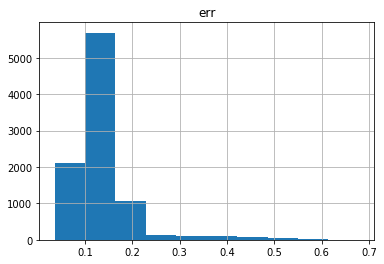

In [46]:
err_df.hist('err')

In [47]:
err_df_high = err_df[err_df['err'] > 0.15]

In [48]:
err_df_high.head()

,phonetic,err
1,O,0.283488
6,i,0.193276
8,i,0.230653
14,A,0.226100
18,U,0.159936


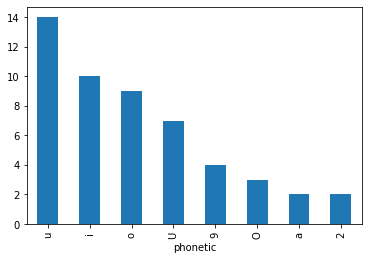

In [49]:
err_df[err_df['err'] > 0.5].groupby('phonetic')['phonetic'].count().sort_values(ascending=False).plot.bar()

In [50]:
err_df_high.groupby('phonetic')['phonetic'].count()

phonetic
2      70
9     184
@     133
A      85
E     174
E:    171
O     193
U     111
a     175
e     209
i     289
o     184
u     218
y     123
Name: phonetic, dtype: int64

## Evaluate each param of each row

In [51]:
se = compute_se(y_test,y_pred)
errs = compute_rmse(y_test,y_pred, axis=1)

In [52]:
df_se = pd.DataFrame(se, columns=["HX","HY","JA","LP","LD","VS","VO","TCX","TCY","TTX","TTY","TBX","TBY","TS1","TS2","TS3","TS4"])

In [53]:
df_se['phonetic'] = z_test
df_se['mean_err'] = errs
df_se['audio'] = a_test

In [54]:
df_se.head()

,HX,HY,JA,LP,LD,VS,VO,TCX,TCY,TTX,TTY,TBX,TBY,TS1,TS2,TS3,TS4,phonetic,mean_err,audio
0,0.044966,0.114307,0.002211,0.072413,0.126587,0.033710,0.402854,0.091562,0.035189,0.012820,0.001042,0.044808,0.007313,0.054798,0.033576,0.066584,0.079148,U,0.115419,"[-0.0036667322, -0.0067870035, -0.009936802, -..."
1,0.357513,0.293304,0.198497,0.147736,0.310341,0.264825,0.395689,0.060571,0.131548,0.210760,0.115824,0.211891,0.311978,0.422195,0.339982,0.459955,0.204212,O,0.283488,"[-0.0077388003, -0.011906635, -0.15257795, -0...."
2,0.033070,0.139970,0.026395,0.117686,0.146222,0.238119,0.279346,0.136286,0.207129,0.019928,0.117553,0.016278,0.163568,0.215327,0.027693,0.032896,0.130082,O,0.145359,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,0.101272,0.049741,0.000629,0.012308,0.009070,0.176167,0.055172,0.007766,0.020521,0.052028,0.001492,0.004869,0.008206,0.075002,0.121391,0.187221,0.004378,U,0.078873,"[0.026149532, 0.034463353, 0.037094187, 0.0368..."
4,0.037142,0.079436,0.146946,0.195756,0.197194,0.011711,0.204950,0.040940,0.024028,0.038695,0.126442,0.127264,0.006106,0.016215,0.083708,0.066435,0.246892,i,0.123012,"[-0.021888198, -0.033991054, -0.042626306, -0...."


In [55]:
df_se[(df_se['phonetic'] == '7') & (df_se['mean_err'] > 0.5)]['TS4'].plot.hist()

TypeError: no numeric data to plot

## EDA audio of testing data 

In [ ]:
df_se_sort = df_se.sort_values('mean_err',ascending=False)
df_se_sort.reset_index(drop=True, inplace=True)

In [ ]:
df_se_sort[df_se_sort['phonetic'] == '&'].head(n=5)

In [ ]:
Audio(df_se_sort['audio'][0], rate=16000)

In [ ]:
df_se_sort[df_se_sort['phonetic'] == '&'].tail(n=5)

In [ ]:
Audio(df_se_sort['audio'][12073], rate=16000)